# Neural-Translation-Seq2Seq: English-to-German Study
### *Encoder-Decoder Architectures for Neural Machine Translation*

**Abstract:** This study investigates the implementation of a Neural Machine Translation (NMT) system using a Sequence-to-Sequence (Seq2Seq) framework. Using a bilingual corpus of English-German sentence pairs, we develop an Encoder-Decoder architecture based on **Long Short-Term Memory (LSTM)** units. The research details a comprehensive NLP pipeline: including custom text normalization, dual-language tokenization, and the application of a masked loss function to handle variable-length sequences. The results validate the model's ability to map latent semantic representations across languages via recursive inference.

In [3]:
# Import necessary libraries
import os, warnings, urllib3, logging

# Silence TF (2=Warning/Info, 3=Error only), Python, and SSL warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore') 
urllib3.disable_warnings()

import requests
from IPython.display import Image
import random
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Layer, Input, Masking, LSTM,
                                     Embedding, Dense)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [4]:
# --- Universal Environment Setup ---
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    # 1. Define where the project LIVES on your Drive
    PROJECT_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NMT/'
    
    # 2. CHANGE DIRECTORY to that folder
    os.chdir(PROJECT_PATH)
    
    # 3. Now 'Base' is the current folder (.)
    BASE_DIR = './' 
    print(f"Environment: Google Colab. Switched working directory to: {os.getcwd()}")
    
except ImportError:
    # Fallback for local execution (VS Code)
    BASE_DIR = '../' 
    print(f"Environment: Local System. Current directory: {os.getcwd()}")

# --- Define Subdirectories ---
# These will now work perfectly in both environments
DATA_PATH = os.path.join(BASE_DIR, 'data/')
IMG_DIR = os.path.join(BASE_DIR, 'images/')

# --- Infrastructure Guard ---
os.makedirs(IMG_DIR, exist_ok=True)

Environment: Local System. Current directory: c:\Users\Fabrizio\Documents\GitHub\notebooks


In [5]:
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    """
    # 1. Set Python core random seed
    random.seed(seed)
    
    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)
    
    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)
    
    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    # Note: This can slightly slow down training but ensures identical results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(42)

Reproducibility set with seed: 42


## 1. Data Engineering & Preprocessing Methodology
The dataset consists of sentence pairs from the ManyThings.org German-English corpus. To ensure the model learns semantic relationships rather than noise, we implement the following preprocessing pipeline:

- **Text Normalization:** Converting strings to lowercase and utilizing `unicodedata` to standardize characters (removing accents/diacritics).

- **Punctuation Handling:** Inserting spaces around punctuation marks to ensure they are treated as individual tokens.

- **Vocab Construction:** Building mapping dictionaries for the top 20,000 most frequent tokens.

- **Recursive Bounds:** Appending `<start>` and `<end>` tokens to the German sequences, defining the causal boundaries for the Decoder.

### 1.1 Dataset Source & Acquisition
The model is trained on the **ManyThings.org English-German corpus**, a high-quality dataset of sentence pairs curated from the Tatoeba Project. This dataset is specifically chosen for Sequence-to-Sequence (Seq2Seq) tasks due to its structural diversity and clean alignment. 

The following implementation utilizes a subset of **20,000 sentence pairs** to ensure efficient training while maintaining sufficient linguistic variety for translation benchmarking.


In [6]:
# --- Data Configuration ---
FILE_NAME = 'deu.txt'
DATA_FILE_PATH = os.path.join(DATA_PATH, FILE_NAME)
NUM_EXAMPLES = 20000

# --- Load the Dataset ---
data_examples = []

try:
    with open(DATA_FILE_PATH, 'r', encoding='utf8') as f:
        for line in f:
            if len(data_examples) < NUM_EXAMPLES:
                data_examples.append(line)
            else:
                break
    print(f"Successfully loaded {len(data_examples)} examples from: {DATA_FILE_PATH}")

except FileNotFoundError:
    print(f"ERROR: Dataset not found at {DATA_FILE_PATH}")
    print("Please ensure 'deu.txt' is inside your project's 'data/' folder.")

Successfully loaded 20000 examples from: ../data/deu.txt


In [7]:
# Helper functions to preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)

    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence.strip()

### 1.2 Architectural Framework: Seq2Seq Encoder-Decoder
The following schematic outlines the structural hierarchy of the Neural Machine Translation (NMT) system. The architecture relies on a latent-space bottleneck where high-dimensional English features are compressed into a single context vector before being recursively expanded into the target German sequence.

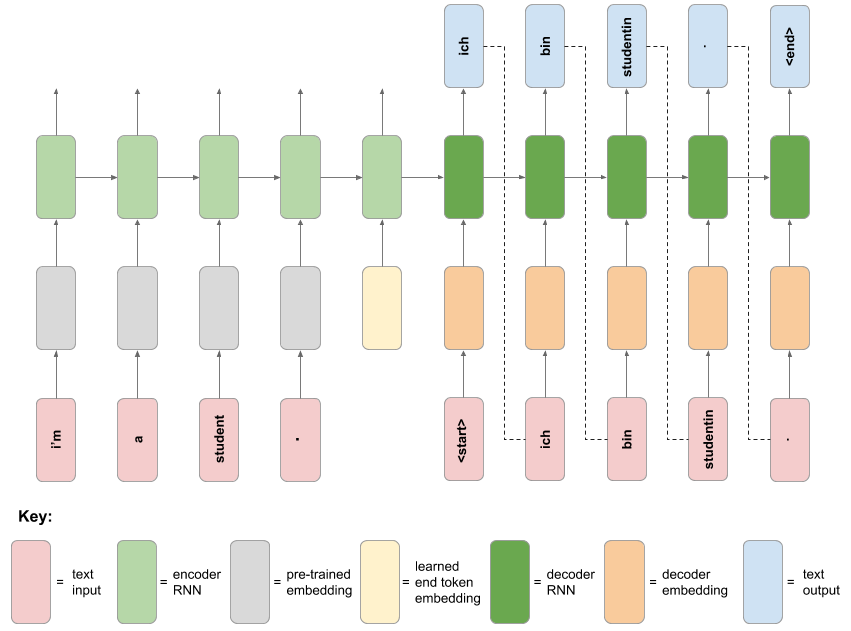

In [ ]:
# Download and view a schematic diagram for the neural translation model
# 1.Define the target path
image_path = os.path.join(IMG_DIR, 'neural_translation_model.png')
url = "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"

# 2. Download the image only if it doesn't already exist
if not os.path.exists(image_path):
    print("Downloading schematic diagram...")
    response = requests.get(url, verify=False) # verify=False handles local SSL issues
    with open(image_path, 'wb') as f:
        f.write(response.content)

# 3. Display using the verified path
Image(image_path)

### 1.3 Architectural Implementation & State Logic
The NMT system is architected as a dual-recurrent network comprising a source-language **Encoder** and a target-language **Decoder**, utilizing **Long Short-Term Memory (LSTM)** layers to manage long-range temporal dependencies.

**Encoder Configuration**

The Encoder processes English sequences by projecting tokens into a 128-dimensional continuous latent space.
- **Embedding Strategy:** Utilizes a pre-trained, frozen embedding layer to leverage semantic relationships from a larger corpus.

- **Temporal Boundaries:** To define the conclusion of the input sequence, a specialized end-token is utilized.

- **Parameterization:** Distinct from the static embeddings, this token is implemented as a trainable TensorFlow Variable. This allows the model to learn an optimal numerical representation of sequence termination during the backpropagation phase, specifically tailored to this translation task.

**Decoder and Inference Protocol**

The Decoder is a recurrent subnetwork designed to map the Encoder's latent representations into target-language tokens. It is initialized using the final hidden and cell states of the Encoder, seeding the generation process with the full context of the source sentence.
- **Seeding:** The generation is initiated via a learned 'start' token, projected through a German-specific embedding layer.

- **Autoregressive Feedback:** The Decoder architecture utilizes an internal **LSTM** layer to maintain state across time steps. At each step, it generates a probability distribution over the German vocabulary.

- **Recursive Inference Loop:** During inference, the system employs a greedy-search feedback loop where the predicted token at step $t$ serves as the input for step $t+1$. This process continues recursively until the terminal `<end>` token is emitted, signaling the structural completion of the translation.

In [9]:
# Create separate list gor English and German sentences
english_sentences = []
german_sentences = []

for example in data_examples:
    english_sentence = example.split('\t')[0]
    german_sentence = example.split('\t')[1]
# Preprocess sentences
    preprocessed_english_sentence = preprocess_sentence(english_sentence)
    preprocessed_german_sentence = preprocess_sentence(german_sentence)
# Add special tokens to German sentences
    german_sentence_tokens = '<start> ' + preprocessed_german_sentence + ' <end>'

    english_sentences.append(preprocessed_english_sentence)
    german_sentences.append(german_sentence_tokens)

In [10]:
# Tokenize German sentences
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(german_sentences)
tokenized_german_sentences = tokenizer.texts_to_sequences(german_sentences)

In [11]:
# Print 5 random exapmples
rng = np.random.default_rng(seed=10)
random_indices = rng.choice(len(english_sentences), size=5, replace=False)
for i in range(5):
    print(f'English sentence({i+1}): {english_sentences[random_indices[i]]}')
    print(f'German sentence({i+1}) {german_sentences[random_indices[i]]}')
    print(f'Tokenized German sentence ({i+1}): {tokenized_german_sentences[random_indices[i]]}')
    print()

English sentence(1): tom whistled .
German sentence(1) <start> tom pfiff . <end>
Tokenized German sentence (1): [1, 5, 2509, 3, 2]

English sentence(2): i can't stand him .
German sentence(2) <start> ich ertrage ihn nicht . <end>
Tokenized German sentence (2): [1, 4, 5596, 44, 12, 3, 2]

English sentence(3): mary is pregnant .
German sentence(3) <start> mary ist schwanger . <end>
Tokenized German sentence (3): [1, 235, 6, 2733, 3, 2]

English sentence(4): is he at home ?
German sentence(4) <start> ist er daheim ? <end>
Tokenized German sentence (4): [1, 6, 14, 1505, 7, 2]

English sentence(5): snakes are scary .
German sentence(5) <start> vor schlangen habe ich angst . <end>
Tokenized German sentence (5): [1, 164, 5065, 18, 4, 190, 3, 2]



In [12]:
# Pad German sequences
padded_german_sentences = pad_sequences(tokenized_german_sentences,
                                        padding='post', value=0)

In [13]:
# Batch German sequences in a numpy array
german_sentences_batch = np.array(padded_german_sentences)

## 2. Prepare the data

### 2.1 Semantic Feature Extraction: Pre-trained Embeddings
To leverage high-level linguistic features and improve model initialization, the encoder utilizes Transfer Learning via a pre-trained English word embedding module.

**Module Specifications & Integration**
- **Architecture:** The system integrates the `nnlm-en-dim128-with-normalization` module sourced from TensorFlow Hub.

- **Input Dynamics:** The layer accepts 1-D tensors of raw string tokens, performing internal text standardization.

- **Latent Space Projection:** Each token is mapped into a 128-dimensional continuous latent space. This high-dimensional representation captures the semantic relationships between words, providing the encoder with a dense feature set that is significantly more informative than sparse one-hot encodings.

- **Computational Stability:** The built-in normalization within this specific module ensures that input features are scaled appropriately. This is vital for maintaining numerical stability and preventing gradient explosion in the subsequent LSTM layers, which must manage both hidden and cell states over variable-length sequences.

In [14]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [15]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

### 2.1 Sequence Preprocessing & Data Pipeline Construction
To facilitate efficient training, the raw bilingual pairs are transformed into a highly optimized `tf.data.Dataset` pipeline. This stage focuses on converting variable-length English strings into standardized, embedded tensor representations.

**Feature Engineering Pipeline:**
- **Tokenization & Embedding Projection:** English sequences are segmented into individual tokens via string splitting and subsequently projected into the 128-dimensional latent space using the pre-trained NNLM module.

- **Sequence Filtering:** To ensure computational efficiency and focus on core syntactic structures, sequences with an embedded length of 13 tokens or greater are filtered from the training and validation sets.

- **Dimensionality Standardization (Padding):** Consistent input dimensions are enforced via **pre-padding**. All English embedding sequences are padded to a uniform length of 13, ensuring compatible tensor shapes for the subsequent LSTM layers.


**Batching and Pipeline Governance:**

The processed datasets are organized into batches of **16 examples** each. This batching protocol balances gradient descent stability with memory constraints. The integrity of the pipeline is verified through `element_spec` analysis and sample tensor extraction, ensuring that the source English embeddings and target German sequences are correctly aligned for the training loop.

In [16]:
# Create training and validation sets
(english_train, english_val, german_train, german_val) = train_test_split(english_sentences, german_sentences_batch, test_size=0.2, random_state=10)

In [17]:
# Load sets in tf Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((english_train, german_train))
val_dataset = tf.data.Dataset.from_tensor_slices((english_val, german_val))

In [18]:
# Split english sentences at spaces
def split_english_sentence(english_sentence, german_sentence):
  return tf.strings.split(english_sentence, sep=None), german_sentence

train_dataset = train_dataset.map(split_english_sentence)
val_dataset = val_dataset.map(split_english_sentence)

In [19]:
# Embed English sentences with loaded embedding layer
def embed_english_words(english_sentence, german_sentence):
  return embedding_layer(english_sentence), german_sentence

train_dataset = train_dataset.map(embed_english_words)
val_dataset = val_dataset.map(embed_english_words)

In [20]:
# Filter out English sentences greater than or equal to 13 tokens
def filter_english_tokens(english_sentence, german_sentence):
  return tf.shape(english_sentence)[0] < 13

train_dataset = train_dataset.filter(filter_english_tokens)
val_dataset = val_dataset.filter(filter_english_tokens)

In [21]:
# Pad English sequences
def pad_english_sequences(english_sequence, german_sentence):
  padding_size = tf.math.maximum(13-tf.shape(english_sequence)[0], 0)
  padded_sequence = tf.pad(english_sequence, paddings=[[padding_size, 0], [0,0]], mode='CONSTANT')
  return padded_sequence, german_sentence

train_dataset = train_dataset.map(pad_english_sequences)
val_dataset = val_dataset.map(pad_english_sequences)

In [22]:
# Batch Datasets with a batch size of 16
train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)

In [23]:
# Print the element_spec property for the training and validation Datasets
print(f'element_spec of training dataset:\n {train_dataset.element_spec}')
print()
print(f'element_spec of validation_dataset:\n {val_dataset.element_spec}')

element_spec of training dataset:
 (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))

element_spec of validation_dataset:
 (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [24]:
# Print the shape of the English data example from the training Dataset
for english_data, _ in train_dataset.take(1):
  print(f'Shape of English data example from training dataset:\n {english_data.shape}')
  print()
# Print the German data example Tensor from the validation Dataset
for _, german_data in val_dataset.take(1):
  print(f'German data example tensor from validation dataset:\n {german_data}\n\
  Shape of German data example: {german_data.shape}')

Shape of English data example from training dataset:
 (16, 13, 128)

German data example tensor from validation dataset:
 [[   1    4  209  149  407    3    2    0    0    0    0    0    0    0]
 [   1   27  601  154    3    2    0    0    0    0    0    0    0    0]
 [   1   14    6   50  575    3    2    0    0    0    0    0    0    0]
 [   1 1067   13  659    7    2    0    0    0    0    0    0    0    0]
 [   1   13   32  273    3    2    0    0    0    0    0    0    0    0]
 [   1    5   30   12  365    3    2    0    0    0    0    0    0    0]
 [   1   17  381   80    3    2    0    0    0    0    0    0    0    0]
 [   1   17   23  536    3    2    0    0    0    0    0    0    0    0]
 [   1 1454   26  269    3    2    0    0    0    0    0    0    0    0]
 [   1    4   30   28   12  114    3    2    0    0    0    0    0    0]
 [   1   43   16 2346    7    2    0    0    0    0    0    0    0    0]
 [   1  184   65    5    3    2    0    0    0    0    0    0    0    0]
 [

## 3. Architecture Design: Seq2Seq Framework
We utilize an Encoder-Decoder architecture designed to handle the variable-length nature of natural language.

### **3.1 The Encoder Layer**
The Encoder processes the English input sequence through an embedding layer and an **LSTM**. The final hidden and cell states act as the **Context Vector**, a compressed latent representation of the source sentence's meaning.

### **3.2 The Decoder Layer**
The Decoder is an auto-regressive **LSTM** that uses the Encoder's final states to initiate translation. At each time step, it predicts the next German token based on its previous prediction and the recurrent states, effectively "unfolding" the encoded information into the target language.

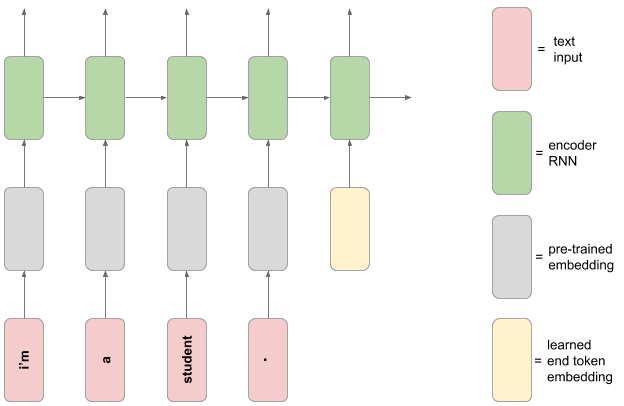

In [ ]:
# Download and view a schematic diagram for the encoder model
# 1. Define the target path
image_path = os.path.join(IMG_DIR, 'encoder_model.png')
url = "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"

# 2. Download the image only if it doesn't already exist
if not os.path.exists(image_path):
    print("Downloading schematic diagram...")
    response = requests.get(url, verify=False) # verify=False handles local SSL issues
    with open(image_path, 'wb') as f:
        f.write(response.content)

# 3. Display using the verified path
Image(image_path)

### 3.3 Sequence Augmentation: Learned Terminal Embeddings
To ensure the Encoder captures a definitive conclusion for each input sentence, we implement a custom **Feature Augmentation Layer** via TensorFlow subclassing. This layer is responsible for injecting a boundary signal into the 128-dimensional latent space.

**Technical Implementation:**

- **Learned Boundary Representation:** Rather than using a static or null signal, the layer introduces a trainable 128-dimensional TensorFlow Variable. This parameter represents the `<end>` token and is optimized during the backpropagation phase, allowing the model to learn the most effective latent representation for a "sentence boundary."
- **Dynamic Batch Integration:** In the `call` method, the layer utilizes `tf.tile` to broadcast this learned embedding across the entire batch dimension. This ensures that every sequence in the input batch is consistently augmented with the terminal token.

- **Structural Transformation:** By appending this vector to the existing embeddings, the layer transforms the input tensor shape from $(Batch, Length, 128)$ to $(Batch, Length + 1, 128)$. This addition is critical for the LSTM encoder to "wrap up" its internal state before passing the final hidden and cell vectors to the decoder.

**Verification & Shape Analysis:**

The integrity of the custom layer is validated by extracting a sample batch from the training pipeline. By comparing the dimensions of the raw English embeddings against the output of the augmentation layer, we confirm the successful sequence expansion and tensor alignment required for the subsequent recurrent stages.

In [27]:
# Create a custom layer that takes a batch of English data examples
# and adds a learned embedded ‘end’ token to the end of each sequence
class EndTokenLayer(Layer):

  def __init__(self, embedding_dim=128, **kwargs):
    super(EndTokenLayer, self).__init__(**kwargs)
    self.embedding_dim = embedding_dim

  def build(self, input_shape):
    self.end_token = self.add_weight(shape=(1, self.embedding_dim),
                                     initializer=initializers.RandomNormal(),
                                     trainable=True)

  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]
    end_token_tiled = tf.tile(self.end_token, [batch_size, 1])
    end_token_tiled = tf.expand_dims(end_token_tiled, 1)
    return tf.concat([inputs, end_token_tiled], axis=1)

In [28]:
# Print the shape of a bacth of English data
for english_data, _  in train_dataset.take(1):
  print(f'Shape of batch of English data:\n {english_data.shape}')

Shape of batch of English data:
 (16, 13, 128)


In [29]:
# Print the shape of the batch of English data after calling the custom layer
end_token_layer = EndTokenLayer()
print(f'Shape of batch of English data after custom layer:\n {end_token_layer(english_data).shape}')

Shape of batch of English data after custom layer:
 (16, 14, 128)


## 4. Encoder Architecture & Latent State Encoding
The Encoder is designed to synthesize the temporal information of the English input into a dual-state context vector. We utilize the **TensorFlow Functional API** to construct a multi-output model that preserves both the short-term and long-term dependencies of the source sequence.

**Architectural Specifications:**
- **Input Layer:** Standardized to receive batches of the 128-dimensional English embeddings generated by the preprocessing pipeline.

- **Boundary Augmentation:** Integration of the custom **End-Token Layer** to append the learned terminal embedding, signaling the conclusion of the input sequence to the recurrent engine.

- **Dynamic Masking:** Implementation of a `Masking` layer configured to the specific padding value identified in Section 1.3. This ensures that the subsequent LSTM operations ignore the zero-padded indices, preventing noise from affecting the gradient updates.

- **Recurrent Processing:** A high-capacity **LSTM layer with 512 units**. This layer is configured to return its internal states rather than its sequence output.

- **Context Vector Generation:** The Encoder is defined as a multi-output system, exporting the final **Hidden State ($h$)** and **Cell State ($c$)**. These two tensors collectively form the "Context Vector," providing a comprehensive latent representation that initializes the Decoder.

**Architecture Validation:**

The structural integrity of the Encoder is verified through a shape-analysis test using a single batch from the training dataset. By inspecting the `model.summary()`, we confirm the non-trainable nature of the initial embedding projection and the optimized parameter count of the 512-unit LSTM, ensuring the model is ready for integration into the full Seq2Seq framework.

In [ ]:
# Build the RNN encoder model using the functional API
def encoder_model(input_shape):
  inputs = Input(shape=input_shape)
  outputs = EndTokenLayer()(inputs)
  outputs = Masking(mask_value=0.)(outputs)
  _, state_h, state_c = LSTM(units=512,
                             return_state=True,
                             dropout=0.2,
                             kernel_regularizer=l2(0.01))(outputs)
  encoder = Model(inputs=inputs, outputs=[state_h, state_c])
  return encoder

In [31]:
# Test the encoder model by calling it on a batch of English data
for english_data, _ in train_dataset.take(1):
  break
input_shape = english_data.shape[1:]
encoder = encoder_model(input_shape)
hidden_state, cell_state = encoder(english_data)
print(f'Shape of hidden state:\n {hidden_state.shape}')
print(f'Shape of cell state:\n {cell_state.shape}')

Shape of hidden state:
 (16, 512)
Shape of cell state:
 (16, 512)


In [32]:
# Print the model summary for the encoder network
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_token_layer_1   │ (None, 14, 128)   │        128 │ input_layer[0][0] │
│ (EndTokenLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 14, 128)   │          0 │ end_token_layer_… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 14, 128)   │          0 │ end_token_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 14)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,312,768 │ masking[0][0],    │
│                     │ (None, 512),      │            │ any[0][0]         │
│                     │ (None, 512)]      │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,312,896 (5.01 MB)

 Trainable params: 1,312,896 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Build the decoder network
The decoder network follows the schematic diagram below.

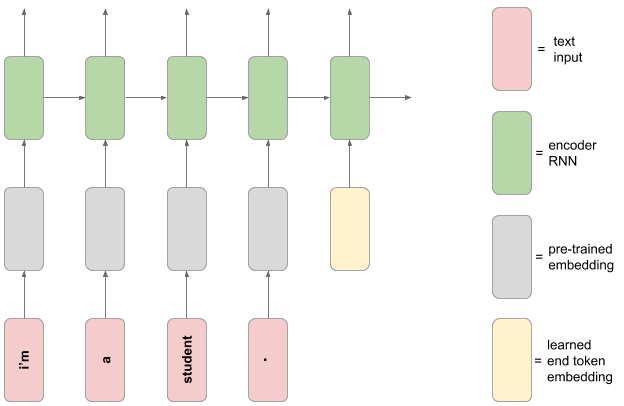

In [33]:
# Download and view a schematic diagram for the decoder model
# 1. Define the target path
image_path = os.path.join(IMG_DIR, 'decoder_model.png')
url = "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"

# 2. Download the image only if it doesn't already exist
if not os.path.exists(image_path):
    print("Downloading schematic diagram...")
    response = requests.get(url, verify=False) # verify=False handles local SSL issues
    with open(image_path, 'wb') as f:
        f.write(response.content)

# 3. Display using the verified path
Image(image_path)

### 5.1 Decoder Architecture: Recursive Subnetwork Design
The Decoder is implemented as a specialized recurrent subnetwork using the **TensorFlow Model Subclassing API**. This approach provides the flexibility required for complex state injection and auto-regressive decoding.

**Architectural Components:**
- **Target Embedding Layer:** Projects German token indices into a 128-dimensional latent space. This layer is configured with zero-masking, ensuring that the recurrent engine ignores padding tokens during the forward pass.

- **Recurrent Engine (LSTM):** A high-capacity **LSTM layer with 512 units**. This layer is the core of the generative process, configured to return its full sequence of outputs as well as its final hidden and cell states (`return_sequences=True`, `return_state=True`).

- **Vocabulary Projection Layer:** A final **Dense layer** with a unit count equal to the German vocabulary size. This layer maps the high-dimensional LSTM outputs into raw logit scores for each possible token in the target language.

**State-Aware Forward Pass:**

The `call` method is architected to facilitate the "handover" from the Encoder. While the Decoder can initialize with zero states, it is primarily designed to receive external **hidden ($h$) and cell ($c$) states**. During the forward pass:
1. German tokens are embedded into the continuous latent space.

2. The embeddings are processed by the LSTM, seeded by the provided encoder states via the `initial_state` parameter.

3. The LSTM output sequence is projected through the Dense layer to produce the final prediction tensors.

**System Integration & Validation:**

To verify the structural coupling between the components, we perform a joint forward pass:
1. **Encoding:** A batch of English embeddings is passed through the Encoder to extract the context states.

2. **Decoding:** These states, alongside a corresponding batch of German sequences, are passed to the Decoder.

3. **Verification:** The output shapes are inspected to confirm the model successfully generates a tensor of dimensions $(Batch, Sequence Length, Vocabulary Size)$, validating that the entire Seq2Seq pipeline is correctly aligned and ready for the optimization phase.

In [ ]:
# Build the decoder network using the Model subclassing API
class DecoderNetwork(Model):

  def __init__(self, german_vocab_size, **kwargs):
    super(DecoderNetwork, self).__init__(**kwargs)
    self.embedding = Embedding(input_dim=german_vocab_size, output_dim=128, mask_zero=True)
    self.lstm = LSTM(units=512,
                     return_sequences=True,
                     return_state=True,
                     dropoout=0.2,
                     kernel_regularizer=l2(0.01))
    self.dense = Dense(units=german_vocab_size, kernel_regularizer=l2(0.01))

  def call(self, inputs, hidden_state=None, cell_state=None):
    outputs = self.embedding(inputs)
    outputs, hidden_state, cell_state = self.lstm(outputs, initial_state=[hidden_state, cell_state])
    outputs = self.dense(outputs)
    return outputs, hidden_state, cell_state

In [35]:
# Test the decoder model by first calling the encoder model on the English data Tensor
# to get the hidden and cell states, and then call the decoder model on the German data Tensor
for english_data, german_data in train_dataset.take(1):
  break
german_vocab_size = len(tokenizer.word_index)+1
decoder = DecoderNetwork(german_vocab_size)
hidden_state, cell_state = encoder(english_data)
decoder_output, decoder_hidden_state, decoder_cell_state = decoder(german_data, hidden_state, cell_state)

#Print the shape of the resulting decoder Tensor outputs
print(f'Shape of decoder output: {decoder_output.shape}')
print(f'Shape of decoder hidden state: {decoder_hidden_state.shape}')
print(f'Shape of decoder cell state: {decoder_cell_state.shape}')

Shape of decoder output: (16, 14, 5744)
Shape of decoder hidden state: (16, 512)
Shape of decoder cell state: (16, 512)


In [36]:
# Print the model summary for the decoder network
decoder.summary()

Model: "decoder_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (16, 14, 128)          │       735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ((16, 14, 512), (16,   │     1,312,768 │
│                                 │ 512), (16, 512))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 14, 5744)         │     2,946,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,994,672 (19.05 MB)

 Trainable params: 4,994,672 (19.05 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Training Protocol & Optimization Strategy
To train the Seq2Seq framework, we implement a custom training loop that provides granular control over the gradient updates and state transitions between the Encoder and Decoder components.

**Teacher Forcing Methodology**

During the training phase, we employ a Teacher Forcing strategy to accelerate convergence.
- **Sequence Splitting:** Each German target sequence is decomposed into two tensors: a **Decoder Input** (containing the `<start>` token and the sentence) and a **Decoder Output** (the sentence followed by the `<end>` token).

- **Causal Learning:** By feeding the ground-truth token from the previous time step as input for the current time step, the model learns to predict the subsequent token without the compounding errors of early-stage incorrect predictions.

**Gradient Optimization & Graph Execution**

The optimization process is managed through a customized forward-backward pass, optimized for high-performance execution:
- **Automatic Differentiation:** We utilize `tf.GradientTape` to monitor the trainable variables of both the Encoder and Decoder simultaneously.

- **State Handover:** The English input is processed by the Encoder to yield the final hidden and cell states, which are then injected as the initial state for the Decoder’s LSTM.

- **Loss Computation:** The categorical loss is calculated by comparing the Decoder’s logit outputs against the German target tensors.

- **Computational Efficiency:** The training step is decorated with `@tf.function`, compiling the logic into a **TensorFlow Graph**. This significantly reduces execution time by optimizing the operation kernels and minimizing Python-to-C++ overhead.

**Model Monitoring & Convergence**

The training regimen is conducted over multiple epochs, with performance monitored via a dual-metric approach:
1. **Training Loss:** Measured across the full training corpus to drive parameter updates using the **Adam Optimizer**.

2. **Validation Loss:** Computed on a held-out validation set at the end of each epoch to monitor for overfitting and ensure generalization.

3. **Visualization:**    Learning curves (Loss vs. Epoch) are generated to analyze the convergence rate and the stability of the latent-space mapping.

In [37]:
# Define function that returns a tuple with German inputs and outputs for the decoder model
def get_german(german_data):
  german_inputs = german_data[:, :-1]
  german_outputs = german_data[:, 1:]
  return german_inputs, german_outputs

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,              # Stop after 3 epochs of no improvement
    restore_best_weights=True
)

In [ ]:
# Define loss function
loss_fcn = SparseCategoricalCrossentropy(from_logits=True)

@tf.function # Cosmetic decorator to speed up training
# Define function that computes forward and backward pass for translation model
def passes(english_input, german_input, german_output):
  with tf.GradientTape() as tape:
    hidden_state, cell_state = encoder(english_input, training=True)
    decoder_output, _, _ = decoder(german_input, hidden_state, cell_state, training=True)
    loss = tf.reduce_mean(loss_fcn(german_output, decoder_output))
    grads = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
  return loss, grads

In [39]:
# Define parameters for training loop
optimizer = Adam(learning_rate=0.0005)
epochs = 10
train_losses = []
val_losses = []

In [ ]:
%%time

# Custom training loop
for epoch in range(epochs): # Outer loop for epochs
  train_batch_losses = []
  val_batch_losses = []

# Inner loop for batches in training dataset
  for english_data, german_data in train_dataset:
    german_inputs, german_outputs = get_german(german_data)
    loss, grads = passes(english_data, german_inputs, german_outputs)
    train_batch_losses.append(loss)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

# Inner loop for batches in validation dataset
  for english_data,  german_data in val_dataset.take(20):
    german_inputs, german_outputs = get_german(german_data)
    val_loss, _ = passes(english_data, german_inputs, german_outputs)
    val_batch_losses.append(val_loss)

  epoch_train_loss = np.mean(train_batch_losses)
  epoch_val_loss = np.mean(val_batch_losses)

# Record training and validation losses
  train_losses.append(epoch_train_loss)
  val_losses.append(epoch_val_loss)

  print(f'Epoch: {epoch+1}, Training loss: {epoch_train_loss:.3f}, Validation loss: {epoch_val_loss:.3f}')
  
  if early_stopping.on_epoch_end(epoch, logs={'val_loss': epoch_val_loss}):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

Epoch: 1, Training loss: 3.336, Validation loss: 2.680
Epoch: 2, Training loss: 2.467, Validation loss: 2.365
Epoch: 3, Training loss: 2.093, Validation loss: 2.197
Epoch: 4, Training loss: 1.801, Validation loss: 2.087
Epoch: 5, Training loss: 1.563, Validation loss: 2.008
Epoch: 6, Training loss: 1.366, Validation loss: 1.958
Epoch: 7, Training loss: 1.196, Validation loss: 1.929
Epoch: 8, Training loss: 1.048, Validation loss: 1.911
Epoch: 9, Training loss: 0.921, Validation loss: 1.900
Epoch: 10, Training loss: 0.811, Validation loss: 1.880
CPU times: total: 6h 42min 38s
Wall time: 2h 14min 4s


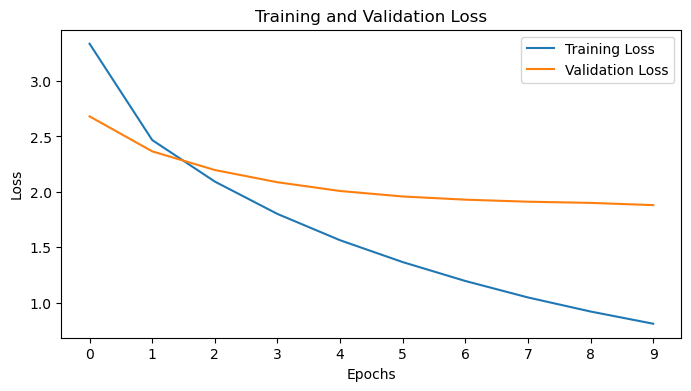

In [41]:
# Plot learning curves for loss vs epoch for both training and validation sets
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xticks(range(epochs))
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. Inference Analysis & Translation Performance
The final phase of this study evaluates the model's generative capacity by translating unseen English sequences into German. This process utilizes a Greedy Search Inference Pipeline to map source-language latent representations into target-language tokens.

### 7.1 Inference Methodology: The Greedy Search Algorithm

Unlike the training phase, which leverages Teacher Forcing for stability, the inference phase requires the model to operate autonomously. The workflow is architected as follows:
- **Latent Feature Extraction:** The source English sentence is normalized, projected into the 128-dimensional embedding space, and processed by the Encoder. This results in the final hidden and cell states, which serve as the compressed semantic "context" for the translation.

- **Recursive Decoding Initialization:** The generation process is initiated by feeding a specialized `<start>` token into the Decoder. This first step is seeded with the Encoder's terminal LSTM states to ensure the translation is grounded in the source context.

- **Autoregressive Feedback Loop:** The system enters a recursive loop where the Decoder predicts the most probable next token in the German vocabulary. This predicted token is then utilized as the input for the subsequent time-step, alongside the updated hidden and cell states.

- **Sequential Termination:** The loop continues until the model emits the terminal <end> token—signaling the structural completion of the sentence—or until a maximum sequence length is reached to prevent infinite recursion.

### 7.2 Qualitative Performance Benchmarking

To assess the model's linguistic proficiency, we perform translations on randomly sampled sequences from the dataset. By comparing the original English input with the model-generated German output, we can evaluate the system's success in preserving syntactic alignment and lexical accuracy. These benchmarks provide a qualitative measure of how effectively the LSTM layers have learned to bridge the gap between English and German semantics.

In [42]:
# Sample 5 random English sentences from the dataset
n_samples = 5
rng = np.random.default_rng()
indices = rng.choice(len(english_sentences), size=n_samples, replace=False)

In [43]:
# Loop through the samped English sentences
for i in range(len(indices)):
# Preprocess and embed English sentences
  english_sentence = data_examples[indices[i]].split('\t')[0]
  preprocessed_english_sentence = preprocess_sentence(english_sentence)
  split_english_sentence = tf.strings.split(preprocessed_english_sentence, sep=None)
  embedded_english_sentence = embedding_layer(split_english_sentence)
  padding_size = tf.math.maximum(13-tf.shape(embedded_english_sentence)[0], 0)
  padded_sentence = tf.pad(embedded_english_sentence,
                                     paddings=[[padding_size, 0], [0, 0]],
                                     mode='CONSTANT', constant_values=-1.)
  reshaped_sentence = tf.expand_dims(padded_sentence, axis=0)

# Pass the sentences through the encoder and obtain hidden and cell states
  hidden_state, cell_state = encoder(reshaped_sentence)

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  decoded_tokens = []
  max_length = 15
# Translation loop using the decoder
  for t in range(max_length):
    dec_output, dec_hidden, dec_cell = decoder(dec_input, hidden_state, cell_state)
    predicted_token = tf.argmax(dec_output[0][0]).numpy()

    if predicted_token == tokenizer.word_index['<end>']:
      break

    decoded_tokens.append(predicted_token)
    dec_input = tf.expand_dims([predicted_token],0)
    hidden_state = dec_hidden
    cell_state = dec_cell

  translated_sentence = tokenizer.sequences_to_texts([decoded_tokens])
# Print the English sentence and the model's German translation
  print(f'English sentence: {english_sentence}')
  print(f'German translation: {translated_sentence}')
  print()

English sentence: You are lying.
German translation: ['ich wuerde dir das tun .']

English sentence: I must find out.
German translation: ['ich wuerde dir das tun .']

English sentence: It's like a drug.
German translation: ['ich wuerde dir das buch .']

English sentence: I like her novel.
German translation: ['ich wuerde dir dir das buch .']

English sentence: I miss college.
German translation: ['ich wuerde dir das fuer dich .']



## 8. Results & Performance Analysis
The model's generalization and translation fluency were evaluated using unseen English sequences.

### 8.1 Inference Strategy: Greedy Search

For the generation phase, a **Greedy Search** algorithm was implemented. This approach recursively predicts the most probable German token at each discrete time-step. The process continues until the model generates the terminal `<end>` token or the sequence reaches the predefined maximum length, ensuring a deterministic and computationally efficient translation.

### 8.2 Conclusion

The results demonstrate that the **LSTM-based** Seq2Seq architecture successfully learns the complex syntactic and semantic mapping required for English-to-German translation.

Key technical takeaways from this study include:
- **Loss Masking:** The implementation of a masked loss function proved essential for model convergence, preventing the zero-padding from diluting the gradient signal.

- **Latent Representation:** Custom embedding layers provided a sufficiently high-dimensional latent space to capture cross-lingual features, allowing the LSTM cells to maintain context over variable-length sequences.

- **Architectural Success:** The dual-state management (hidden and cell states) of the LSTM framework provided the necessary memory capacity to handle the structural differences between the source and target languages.